In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Homework 4: Let's simulate a microscope

The goal of this homework assignment is to create a physically accurate simulation of an optical microscope. This should give you an idea of how to treat an imaging system as a black box linear system, by performing filtering in the Fourier domain. This type of model is also applicable to imaging with other EM radiation, ultrasound, MRI, CT etc.

This simulation will: 

1. Illuminate a thin sample (with finite thickness variations) with light from a particular angle
2. The emerging light will then propagate from the sample to the microscope lens,
3. The light will be filtered by the microscope lens, 
4. And then will continue to the image sensor and will be detected by the image sensor.

Because things are small within a microscope, you have to treat light as a wave. So, we'll be defining the sample, illumination and lens effects as complex-valued vectors.

As a first step, you should define all of the variables of interest and an (x,y) coordinate system for the sample. The variables will include the size of the sample, which we can make 0.25 mm (this is a normal size for a microscope sample). To model the object in the computer, we will need to form a discretized representation of the sample. Thanks to the sampling theorem, that is easily doable. While the composition of the sample can contain any sized feature, down to the sub-nanometer scale, the smallest feature that we'll be able to observe optically with the microscope is limited by the wavelength of light (this is a fundamental pysical limit). Accordingly, when we go about discretizing the sample, the smallest feature that we'll be able to see within the simulated sample, $\Delta x$, will be set at half the wavelength of light.

Let's assume the wavelength of light that we'll use is $\lambda$=0.5 $\mu$m (which is greenish light). We can then select the number of discrete elements to split the sample up into as 1000. You can use the np.linspace function to create x and y axes, and the np.meshgrid function to generate a 2D array of x and y values that will be useful later.

In [ ]:
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

Next, read in an image to use as the test sample. We have included a test target image that is useful to check the resolution of the microscope with. In addition to simulating a sample with this image, please feel free to also use another image of your choice to create a simulated sample. 

For the assignment, please use the test target image to simulate two different types of sample: one that has both absorption and phase delay (as in the code below), and then later for question (c), one that is only absorptive.

The sample_phase definition deserves a bit of explanation. As explained in class, the phase represents the optical thickness of the specimen. Since it is not easy to find datasets of aborption and optical thickness, here we'll just use an image that represents absorption, and then make an approximation to estimate its optical thickness. We will assume that the sample's optical thickness is directly proportional to how much light is absorbed (hope it is clear from the equation why that is the case!)  

In [ ]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

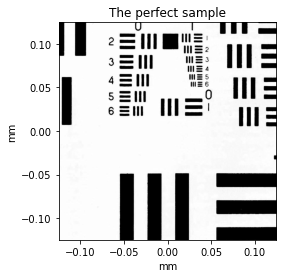

In [ ]:
# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

# show absolute value of sample = its absorption
plt.figure()
plt.imshow(np.abs(sample), extent=(x[0], x[-1], y[0], y[-1]))
plt.title('The perfect sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Next, let's model a plane wave hitting this thin sample. I've written down the general form of a plane wave for you guys below. Note that you can simulate the plane wave hit the sample at a desired angle ($\theta_x$,$\theta_y$).

In [ ]:
# Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

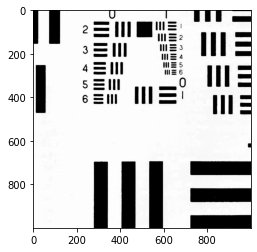

In [ ]:
plt.imshow(np.abs(emerging_field))

Now, let's propagate this field to the lens aperture plane via a Fourier transform, to create the sample spectrum. It is also helpful to define a set of coordinates $(f_x,f_y)$ at this Fourier transform plane. You can use the $(x,y)$ coordinates that you formed above, as well as the relationship $2f_x^{max}=1/\Delta x$, to define the $(f_x,f_y)$ coordinates. That is,  the full range of the spatial frequency axis is inversely proportional to the smallest step size in the spatial axis. And plot the magnitude of the sample spectrum with a set of marked and labeled axes (like for the sample in space). It is helpful to plot it on a log scale for visualization.

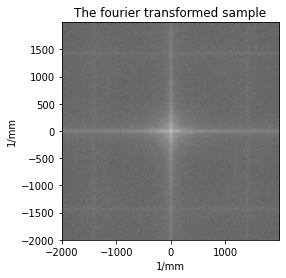

In [ ]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

Next, define the lens transfer function as a circle with a finite radius in the spatial frequency domain. Inside the circle the value of the transfer function is 1, and outside it is 0. Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates. The diameter is set by a parameter called the lens numerical aperture. 

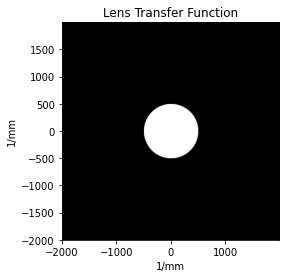

In [ ]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

You can now filter the sample spectrum with the lens transfer function, propagate this filtered spectrum to the image plane, and sample it on a detector that only detects the intensity of light, as we've shown in class. Let's assume the magnification of the lens is 5X (meaning the image of the sample at the detector plane is 5X larger than it is at the lens plane). And display the resulting image on a new coordinate system, $(x',y')$ which represent the coordinates at the detector plane.

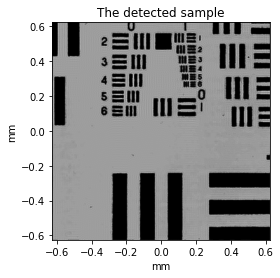

In [ ]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Ok, we've simulated a microscope image! Great! Now let's try to change a few parameters to see what happens. Please try out the following tests and briefly answer the following questions:

(a) Let's try changing the illumination angle by 5 degrees in x coordinate. What happens to sample spectrum at the aperture plane? Why does that change the appearance of the image? 

(b) Try again with a larger angle of illumination that changes the appearance of the image dramatically, such that the background of the image becomes black. This is called a "dark-field" image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur?

(c) Let's change the lens numerical aperture with 0 angles of illumination. Instead of a circle having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with a lens diameter that is 10% of the width of the frequency domain. How does the appearance of the image change? And why?

(d) Next, let's try a wider lens with 50%. Describe how the appearance of the image changes and why. 

(e) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why? Still do not change the angle of illumination.

# (a)

In [ ]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

# Change incident angle 5 degrees in x direction
plane_wave_angle_x = 5 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

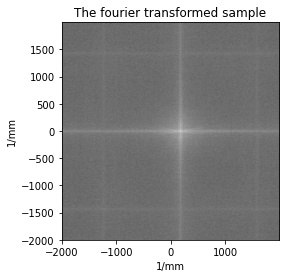

In [ ]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

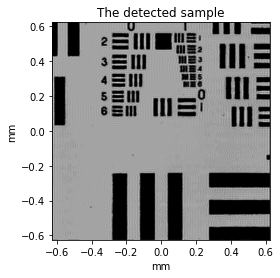

In [ ]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))


# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

By changing the illumination angle by only 5 degrees in the x direction, the image doesn't change too much. Because we are changing the angle of the incoming radiation by some small value in the x direction, light is going to propagate and diffract through the aperture differently causing a distortion in the illumination pattern of the image. This will cause some parts of the image to be heavily distorted. In addition, some of the light is filtered out, causing the image to appear slightly darker. This is not too apparent in part a since we are only changing the angle by a very small amount, but becomes increasingly obvious in part b.

# (b)

In [ ]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

def ill_angle(i):
  response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
  img = Image.open(BytesIO(response.content))
  sample = np.array(img)

  wavelength = .5e-3          # units are mm
  delta_x = 0.5*wavelength
  num_samples = 1000

  # Define the spatial coordinates of the sample
  starting_coordinate = (-num_samples/2) * delta_x
  ending_coordinate = (num_samples/2 - 1) * delta_x

  # make linspace, meshgrid coordinates as needed
  x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  xx, yy = np.meshgrid(x, y)

  # Define sample absorption
  sample = sample/sample.max()
  # Add in sample phase delay  - assume sample thickness linearly proportional to absorption
  sample_phase = 1 - sample
  optical_thickness = 20 * wavelength
  sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

  # Change incident angle i degrees in x direction
  plane_wave_angle_x = i * np.pi/180
  plane_wave_angle_y = 0 * np.pi/180
  illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

  # Define field emerging from sample
  emerging_field = np.multiply(illumination_plane_wave, sample)
  # define total range of spatial frequency axis, 1/mm
  f_range = int(1/delta_x)
  num_samples =  1000
  delta_fx = f_range/num_samples

  # make linspace, meshgrid as needed
  starting_coordinate = (-num_samples/2) * delta_fx
  ending_coordinate = (num_samples/2 - 1) * delta_fx
  xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  xxf, yyf = np.meshgrid(xf, yf)

  # Take 2D fourier transform of sample
  fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

  #begin figure making
  f = plt.figure(figsize=(10,10))

  # plot the Fourier transform of the sample in inverse mm coordinates
  ax = f.add_subplot(121)
  ax.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]), cmap="gray")
  ax.title.set_text('The fft sample for {} degrees changed'.format(i))
  #plt.xscale("log"); plt.yscale("log")
  ax.set_xlabel('1/mm');  ax.set_ylabel('1/mm')
  # Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
  d =int((ending_coordinate - starting_coordinate+1) / 4)
  r = d/2

  # Define lens transfer function as matrix with 1's within desired radius, 0's outside
  trans = np.zeros((num_samples, num_samples))
  dist = np.sqrt((xxf)**2+(yyf)**2)
  trans[np.where(dist<r)]=1

  # Create filtered sample spectrum
  filtered_sample = np.multiply(fourier_field, trans)

  # Define spatial coordinates at image plane, using magnification
  starting_coordinate = (-num_samples/2) * delta_x * 5
  ending_coordinate = (num_samples/2 - 1) * delta_x * 5

  # make linspace, meshgrid coordinates as needed
  x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
  xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

  # Propagate filtered sample spectrum to image plane
  inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

  # Detect intensity (squared magnitude) of resulting field on sensor
  detected_field = np.square(np.abs(inverse_fourier_field))


  # Plot resulting image
  ax2 = f.add_subplot(122)
  # ax2.clf()
  ax2.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]), cmap="gray")
  ax2.title.set_text('Detected sample with {} degrees changed'.format(i))
  ax2.set_xlabel('mm');  ax2.set_ylabel('mm')

  plt.show()

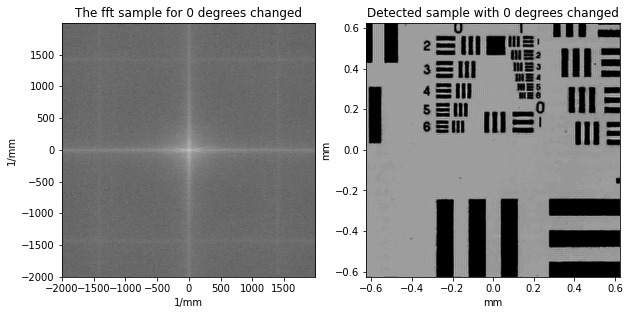

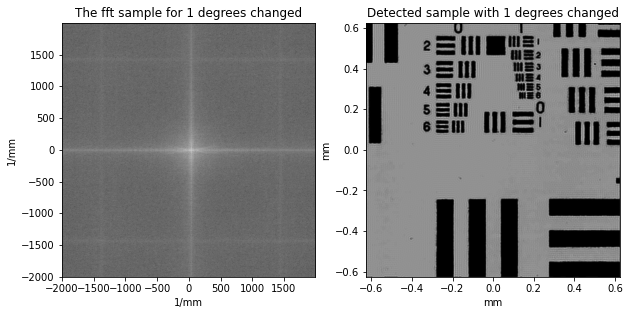

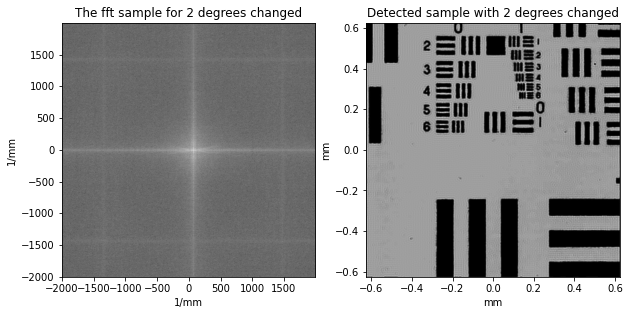

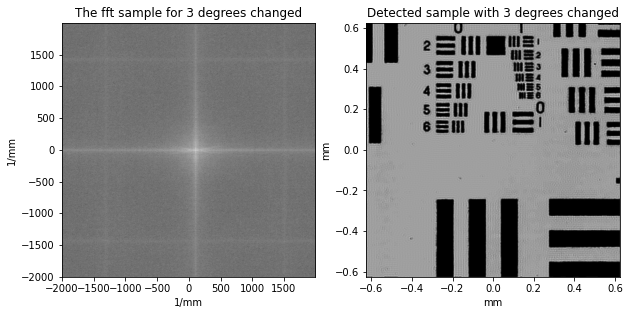

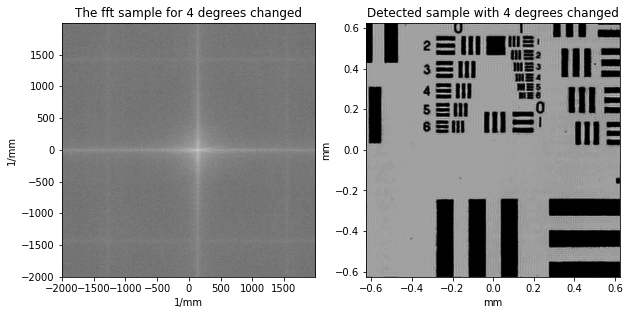

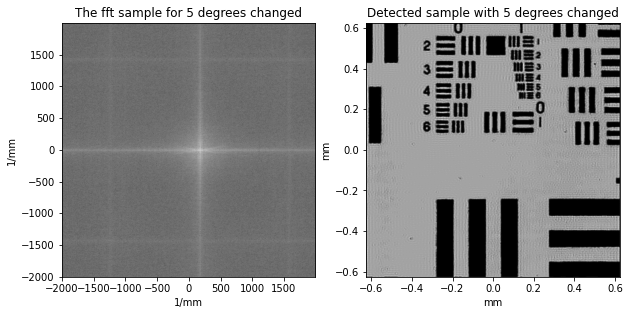

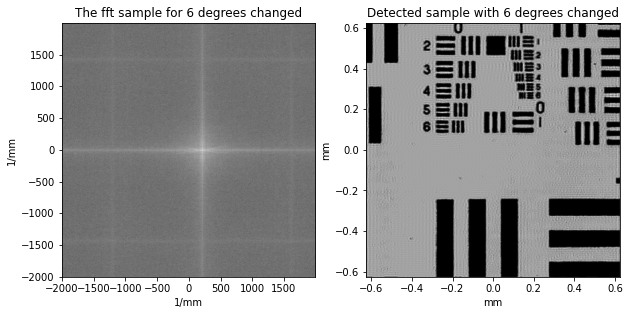

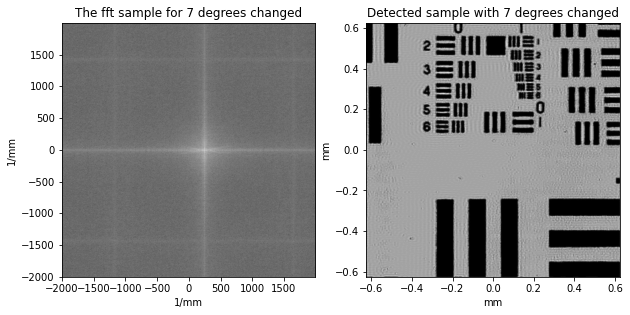

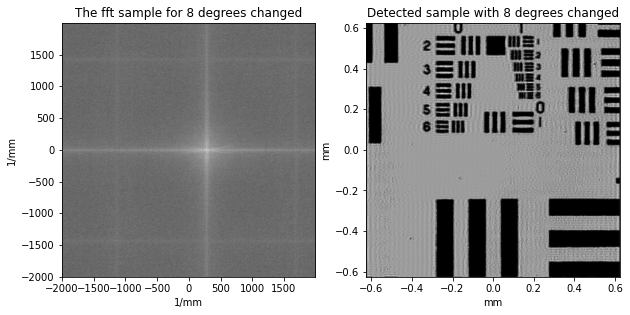

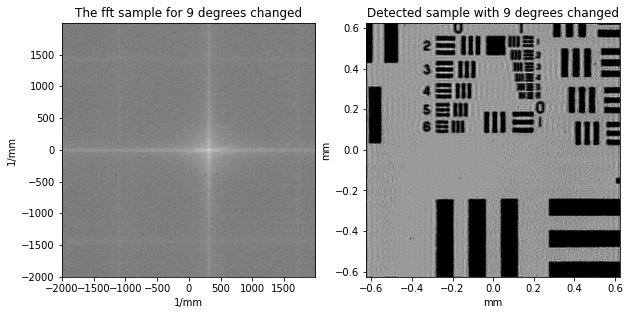

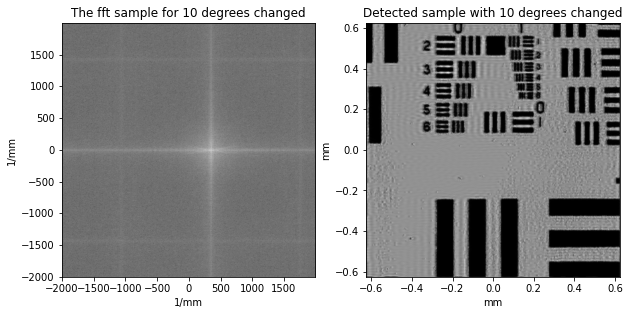

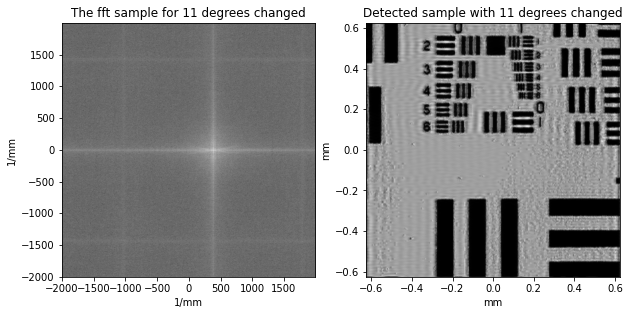

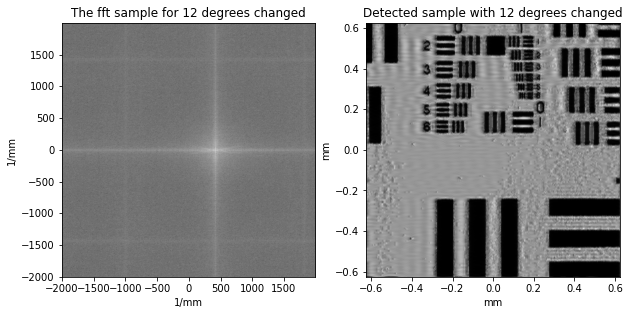

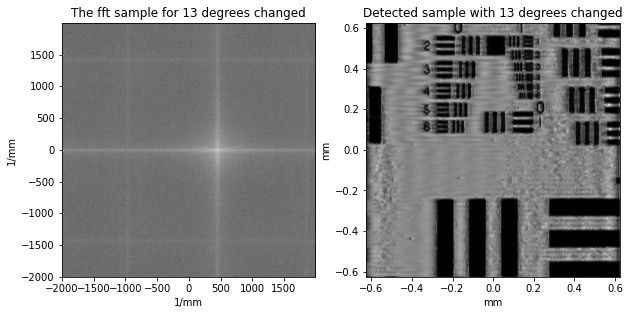

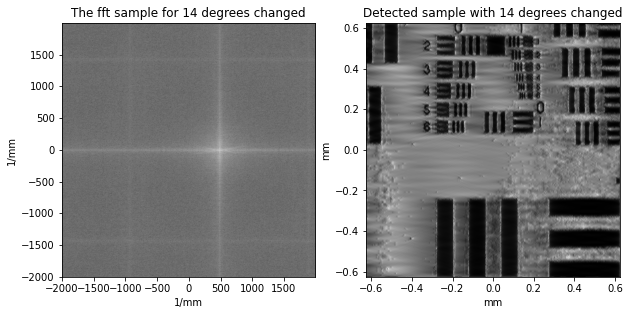

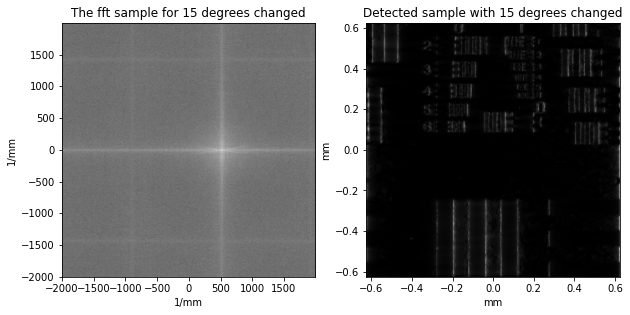

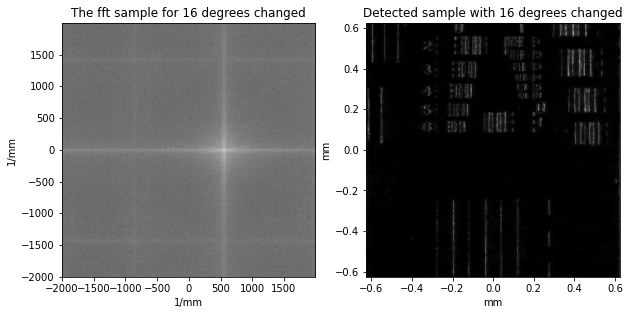

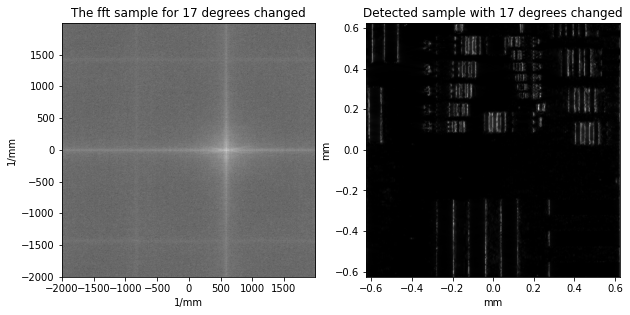

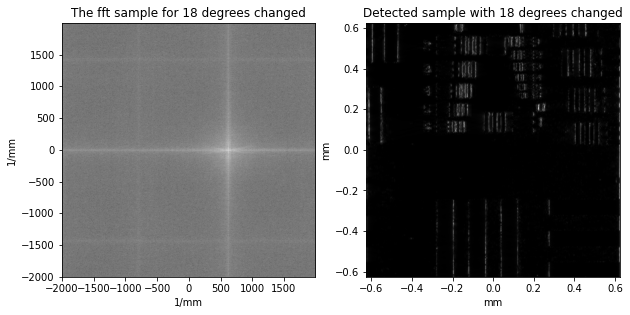

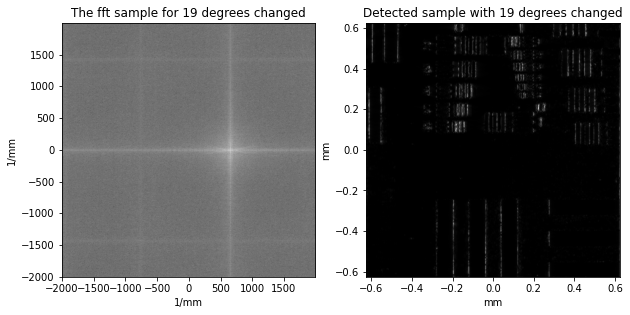

In [ ]:
for i in range(0, 20):
  ill_angle(i)

After changing the angle of illuimination about 15 degrees in the x direction,the image starts to appear very dark. This is because most of the incoming radiation is being filtered out, and areas that were once illuminated by the incoming radiation are now not absorbing many photons anymore. This causes areas that were once bright to become much darker as less photons are absorbed.

# (c)

In [ ]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

# Change incident angle 5 degrees in x direction
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

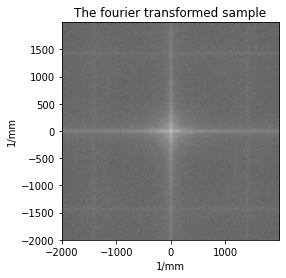

In [ ]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.clf()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

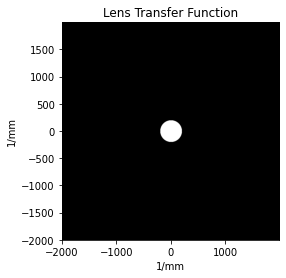

In [ ]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 10)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

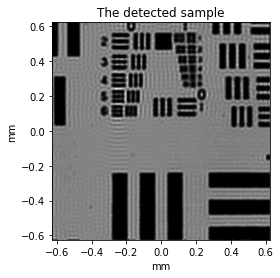

In [ ]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

When making the lens smaller (10% of the width of the frequency domain), you filter out a lot of the higher frequency signals, and thus leads to a lower resolution image where we lost some fine details. Take a look at the spacings between the bars nears numbers 5 and 6 in this above image compared to the original image. You can see many details have now been lost by filtering out these higher frequency signals.

# (d)

In [ ]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

# Change incident angle 5 degrees in x direction
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

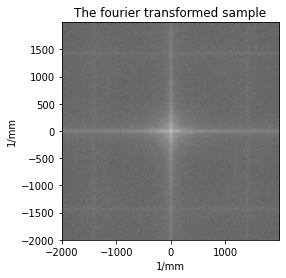

In [ ]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.clf()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

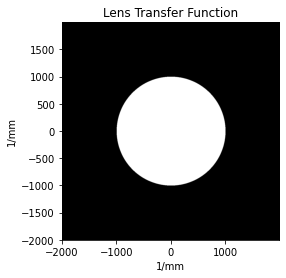

In [ ]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 2)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

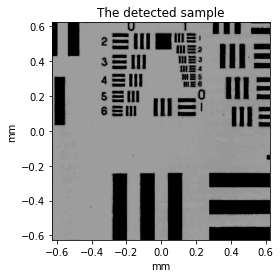

In [ ]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Increasing the lens size to be 50% of the frequency domain does not change the image much from the original image. This is because the sample we are trying to image does not contain many higher frequency signals and all of them are comfortably captured using a lens diameter that is 25% of the width of the frequency domain. So, increasing the lens diameter to be 50% of the frequency isn't going to increase image resolution since no higher frequency signals are really being cut off using the 25% lens.

# (e)

In [18]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

# Change incident angle 0 degrees in x direction
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

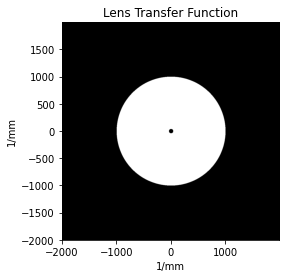

In [19]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 2)
r = d/2

inner_r = d/50

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where((dist<r) & (dist>inner_r))]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

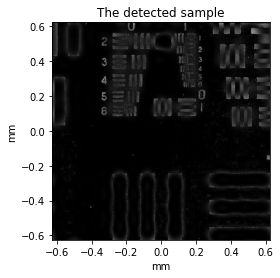

In [20]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

After adding an apodizer to the lens, the image got much darker and a lot of details were lost. This is because the apodizer filters out a lot of the incoming radiation making the image darker and not capturing most of the fine details within the sample. The only details that remain in the image are where there are clear transitions from "light" areas of the image to "darker" areas of the image. For example, where the black bars meet the lighter background, or where the dark numbers meet the lighter background. In other words, edge details are captured well when using the apodizer.